## Snakemake for Converting GMET Forcing to Snakemake ##

Initial workflow file to test capabilities of [snakemake](https://snakemake.readthedocs.io/en/stable/).



In [1]:
from IPython import display

In [113]:
%%writefile ../gmet_to_summa.smk
''' 
gmet to summa snakemake master snakemake file

This snakemake file runs all the steps required to convert GMET forcings to SUMMA forcings.

Original process code: Andy Wood
Adapted to Snakemake: Dave Casson
'''

from pathlib import Path
from scripts import gmet_to_summa_utils as utils

# Resolve paths from the configuration file
config = utils.resolve_paths(config)

# Read in all local snakemake files and rules
include: './rules/gmet_file_prep.smk'
include: './rules/remap_gmet_to_shp.smk'
include: './rules/metsim_file_prep.smk'
include: './rules/run_metsim.smk'
include: './rules/metsim_to_summa.smk'

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
_, file_path_list = utils.build_ensemble_list(config['gmet_forcing_dir'])

rule gmet_to_summa:
    input:
        expand(Path(config['summa_forcing_dir'],'{forcing_file}.nc'), forcing_file = file_path_list)
        

Overwriting ../gmet_to_summa.smk


In [115]:
! snakemake --unlock -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../gmet_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                                            count    min threads    max threads
-------------------------------------------  -------  -------------  -------------
append_hru_id_and_datastep_to_metsim_output        9              1              1
create_hru_id_file                                 1              1              1
create_metsim_domain_summa_attr                    1              1              1
create_state_file                                  9              1              1
generate_metsim_output                             9              1              1
gmet_to_summa                                      1              1              1
prep_forcing_files_with_hru_id                     9              1              1
subset_metsim_domain_to_forcing                    1              1              1
update_state_fil

Building DAG of jobs...


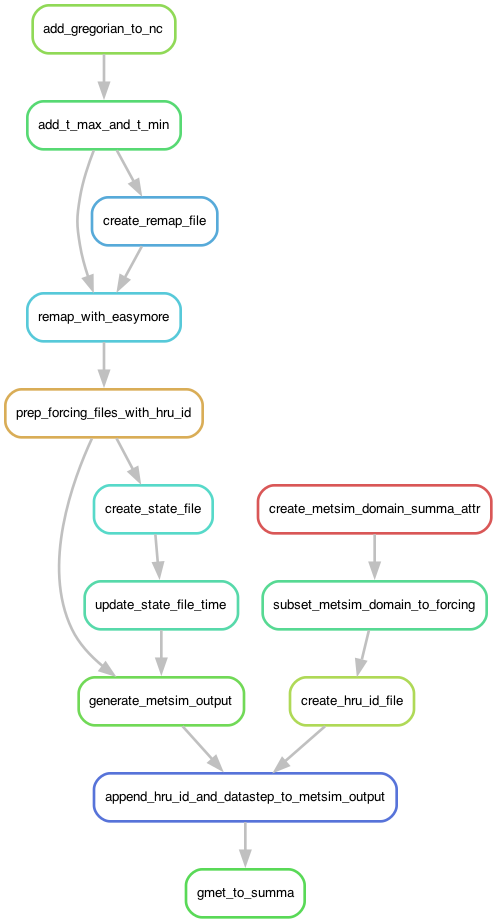

In [116]:
# Snake Command line to build the image
! snakemake -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml --rulegraph | dot -Tpng > ../reports/gmet_to_summa.png
# Python command to visualise the built image in our notebook
display.Image('../reports/gmet_to_summa.png')